<a href="https://colab.research.google.com/github/Amelet/DeepLearning_TensorFLow/blob/main/04_transfer_learning_in_TF_partI_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
import matplotlib.pyplot as plt


Exception ignored in: <function _xla_gc_callback at 0x781074482290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 103, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


In [ ]:
!nvidia-smi

Tue Aug  1 09:05:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import zipfile

# Download teh data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2023-08-01 09:05:13--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.13.128, 74.125.26.128, 172.217.193.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.13.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   123MB/s    in 1.3s    

2023-08-01 09:05:14 (123 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# Unzip the dowloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

In [ ]:
# walk through the downloaded data
import os

for (dirpath, dirnames, filenames) in os.walk("10_food_classes_10_percent"):
  print(f'Dirpath: {dirpath}')
  print(f'Dirnames: {len(dirnames)}')
  print(f'    # of files": {len(filenames)}')
  print('----------------------------------')

Dirpath: 10_food_classes_10_percent
Dirnames: 2
    # of files": 0
----------------------------------
Dirpath: 10_food_classes_10_percent/train
Dirnames: 10
    # of files": 0
----------------------------------
Dirpath: 10_food_classes_10_percent/train/steak
Dirnames: 0
    # of files": 75
----------------------------------
Dirpath: 10_food_classes_10_percent/train/grilled_salmon
Dirnames: 0
    # of files": 75
----------------------------------
Dirpath: 10_food_classes_10_percent/train/ramen
Dirnames: 0
    # of files": 75
----------------------------------
Dirpath: 10_food_classes_10_percent/train/ice_cream
Dirnames: 0
    # of files": 75
----------------------------------
Dirpath: 10_food_classes_10_percent/train/hamburger
Dirnames: 0
    # of files": 75
----------------------------------
Dirpath: 10_food_classes_10_percent/train/sushi
Dirnames: 0
    # of files": 75
----------------------------------
Dirpath: 10_food_classes_10_percent/train/chicken_curry
Dirnames: 0
    # of files

## Create data loaders

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("train images")
train_data_10_percent = train_datagen.flow_from_directory(directory=train_dir,
                                                           target_size=IMAGE_SHAPE,
                                                           batch_size=BATCH_SIZE,
                                                           class_mode='categorical')

print("test images")
test_data_10_percent = test_datagen.flow_from_directory(test_dir,
                                                        target_size=IMAGE_SHAPE,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode='categorical')

train images
Found 750 images belonging to 10 classes.
test images
Found 2500 images belonging to 10 classes.


### Callbacks

In [ ]:
# create TensorBoard callback
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%md-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"saving tensorboard log files to: {log_dir}")
  return tensorboard_callback

### Tensorflow Hub

In [ ]:
## Creating models using TF Hub
# comapre two models:
resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'
efficientnet_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'

### Create model from a URL

In [ ]:
def create_model(model_url, num_classes=10):
  """
  Takes a TensorFDlow Hub URL and create a KEras Sequential model with it.

  Args:
    model_url (str): A TF Hub feature extraction URL
    num_classes (int): Number of output neurons in the output layer
    should be equal to number of target classes (10)

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor layer and
    Dense output layer with num_classes output neurons.
  """
  # Download the pretrained model and
  feature_extraction_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the already learned patterns
                                           name = 'feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,))


  # create our model
  model = tf.keras.Sequential([
      feature_extraction_layer,
      layers.Dense(num_classes,
                  activation="softmax",
                  name="output_layer")
  ])

  return model

# **ResNet** Feature Extraction Model

Create:


In [ ]:
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


Compile:

In [ ]:
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

Fit:

In [ ]:
dir_name = 'tensorflow_hub'
experiment_name = 'resnet50V2'

resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data_10_percent,
                                  validation_steps=len(test_data_10_percent),
                                  callbacks=[create_tensorboard_callback(dir_name, experiment_name)])

saving tensorboard log files to: tensorflow_hub/resnet50V2/202308d-090532
Epoch 1/5
24/24 [==============================] - 27s 575ms/step - loss: 1.9845 - accuracy: 0.3187 - val_loss: 1.2555 - val_accuracy: 0.6032
Epoch 2/5
24/24 [==============================] - 11s 467ms/step - loss: 0.9133 - accuracy: 0.7400 - val_loss: 0.8697 - val_accuracy: 0.7284
Epoch 3/5
24/24 [==============================] - 11s 474ms/step - loss: 0.6273 - accuracy: 0.8227 - val_loss: 0.7605 - val_accuracy: 0.7608
Epoch 4/5
24/24 [==============================] - 11s 481ms/step - loss: 0.4784 - accuracy: 0.8760 - val_loss: 0.7162 - val_accuracy: 0.7724
Epoch 5/5
24/24 [==============================] - 11s 471ms/step - loss: 0.3800 - accuracy: 0.9133 - val_loss: 0.6828 - val_accuracy: 0.7748


In [ ]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.subplot(1,2,1)
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

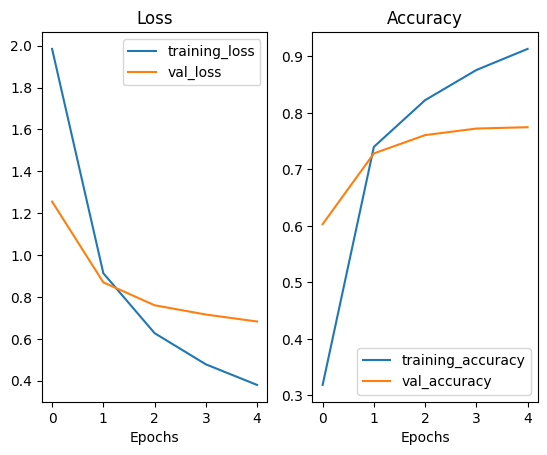

In [ ]:
plot_loss_curves(resnet_history)

# **ResNet** Feature Extraction Model

In [ ]:
# create
efficientnet_model = create_model(efficientnet_url,
                                  num_classes=train_data_10_percent.num_classes)
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
# learn what are the layers in the modle
len(efficientnet_model.layers[0].weights)

309

In [ ]:
# compile
efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer="Adam",
                           metrics=["accuracy"])

# fit
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=10,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data_10_percent,
                                              validation_steps=len(test_data_10_percent),
                                              callbacks=[create_tensorboard_callback("tensorflow_hub", "efficientnetb0")])

saving tensorboard log files to: tensorflow_hub/efficientnetb0/202308d-090714
Epoch 1/10
24/24 [==============================] - 25s 559ms/step - loss: 1.8251 - accuracy: 0.4440 - val_loss: 1.2750 - val_accuracy: 0.7316
Epoch 2/10
24/24 [==============================] - 10s 444ms/step - loss: 1.0452 - accuracy: 0.7587 - val_loss: 0.8628 - val_accuracy: 0.8180
Epoch 3/10
24/24 [==============================] - 10s 446ms/step - loss: 0.7514 - accuracy: 0.8227 - val_loss: 0.6999 - val_accuracy: 0.8416
Epoch 4/10
24/24 [==============================] - 13s 541ms/step - loss: 0.6053 - accuracy: 0.8520 - val_loss: 0.6130 - val_accuracy: 0.8516
Epoch 5/10
24/24 [==============================] - 10s 446ms/step - loss: 0.5145 - accuracy: 0.8760 - val_loss: 0.5605 - val_accuracy: 0.8604
Epoch 6/10
24/24 [==============================] - 11s 456ms/step - loss: 0.4457 - accuracy: 0.9093 - val_loss: 0.5250 - val_accuracy: 0.8668
Epoch 7/10
24/24 [==============================] - 11s 458ms/st

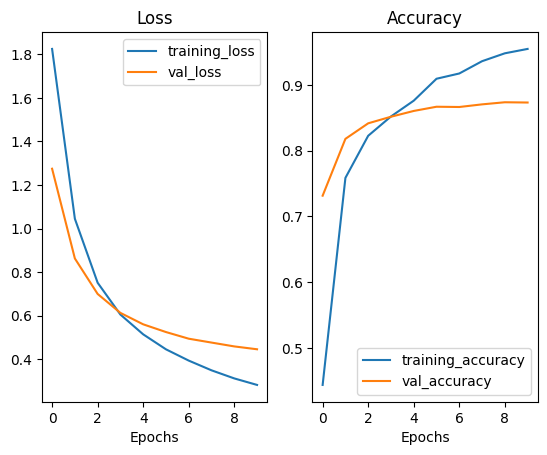

In [ ]:
plot_loss_curves(efficientnet_history)

# Compare result using TensorBoard
experiment is here:  https://tensorboard.dev/experiment/z2gQofWtRsKegODPf34jpg/#scalars


In [ ]:
# Upload TensorBoard dev record
#!tensorboard dev upload --logdir ./tensorflow_hub/ \
#  --name "EfficientNetB0 vs ResNet50V2"  \
#  --description "Compare two different TF Hub feature extraction architectures using 10% of the training data"  \
#  --one_shot

In [ ]:
# check out the experiments we have
#! tensorboard dev list

In [ ]:
# delete an experiment
# !tensorboard dev delete --experiment_id z2gQofWtRsKegODPf34jpg
# then confirm the deletion by checking what experiment you have left
# !tensorboard dev list